# Handover

The network topology consists of one station, two aps, one switch and one host. Their IP and MAC addresses can be found below.

![title](imgs/handover.png)

In [ ]:
# %matplotlib qt # opens plot in a new window

*** Adding stations
*** Adding P4APs
*** Configuring propagation model
*** Connecting to wmediumd server /var/run/wmediumd.sock
*** Adding links
*** Starting network


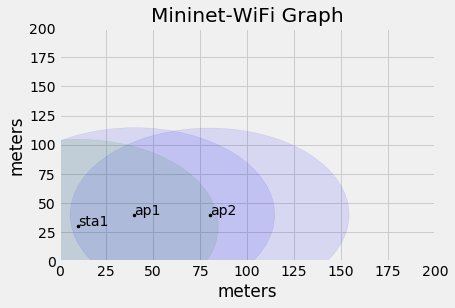

*** Starting controller(s)

*** Starting L2 nodes
s1 

..⚡️ simple_switch_grpc @ 80364 thrift @ 50003


ap1 

..⚡️ simple_switch_grpc @ 80382 thrift @ 50001


ap2 

..⚡️ simple_switch_grpc @ 80408 thrift @ 50002



*** Running CLI
*** Starting CLI:


mininet-wifi> exit


*** Stopping network
*** Stopping 0 controllers

*** Stopping 5 links
.....
*** Stopping switches/access points
s1 ap1 .ap2 .
*** Stopping nodes
h1 sta1 

*** Removing WiFi module and Configurations
*** Killing mac80211_hwsim

*** Done


In [1]:
#!/usr/bin/python

import os
import sys

from mininet.log import setLogLevel, info
from mn_wifi.bmv2 import ONOSBmv2AP, ONOSBmv2Switch
from mn_wifi.cli import CLI
from mn_wifi.link import wmediumd
from mn_wifi.net import Mininet_wifi
from mininet.term import makeTerm
from mn_wifi.wmediumdConnector import interference


def topology():
    'Create a network.'
    net = Mininet_wifi(link=wmediumd, wmediumd_mode=interference)

    info('*** Adding stations\n')
    sta1 = net.addStation('sta1', ip='10.0.0.1', mac="00:00:00:00:00:01",
                          bgscan_threshold=-70, s_inverval=1, l_interval=2,
                          bgscan_module="simple")
    h1 = net.addHost('h1', ip='10.0.0.2', mac="00:00:00:00:00:02")

    path = os.path.dirname(os.getcwd())
    json_file = path + '/p4-scenarios/handover.json'

    info('*** Adding P4APs\n')
    ap1 = net.addAccessPoint('ap1', cls=ONOSBmv2AP, mac="00:00:00:00:00:03",
                             ssid='handover', channel=1, position='40,40,0',
                             passwd='123456789a', encrypt='wpa2', bssid_list=[['00:00:00:00:00:04']],
                             ieee80211r=True, mobility_domain='a1b2',
                             netcfg=True, thriftport=50001, json=json_file)
    ap2 = net.addAccessPoint('ap2', cls=ONOSBmv2AP, mac="00:00:00:00:00:04",
                             ssid='handover', channel=6, position='80,40,0',
                             passwd='123456789a', encrypt='wpa2', bssid_list=[['00:00:00:00:00:03']],
                             ieee80211r=True, mobility_domain='a1b2',
                             netcfg=True, thriftport=50002, json=json_file)
    s1 = net.addSwitch('s1', cls=ONOSBmv2Switch, mac="00:00:00:00:00:05",
                       netcfg=True, thriftport=50003, json=json_file)

    info("*** Configuring propagation model\n")
    net.setPropagationModel(model="logDistance", exp=4)

    net.configureWifiNodes()

    info("*** Adding links\n")
    net.addLink(s1, ap1)
    net.addLink(s1, ap2)
    net.addLink(s1, h1)

    net.plotGraph(max_x=200, max_y=200)

    net.startMobility(time=0)
    net.mobility(sta1, 'start', time=1, position='10,30,0')
    net.mobility(sta1, 'stop', time=59, position='110,30,0')
    net.stopMobility(time=60)

    info('*** Starting network\n')
    net.start()
    net.staticArp()    
    
    ap1.cmd('iw dev ap1-wlan1 interface add mon1 type monitor')
    ap2.cmd('iw dev ap2-wlan1 interface add mon2 type monitor')
    ap1.cmd('ip link set mon1 up')
    ap2.cmd('ip link set mon2 up')

    makeTerm(ap1, cmd="bash -c 'python handover-controller.py mon1 3;'")
    makeTerm(ap2, cmd="bash -c 'python handover-controller.py mon2 4;'")
    makeTerm(sta1, cmd="bash -c 'ping 10.0.0.2;'")

    info('*** Running CLI\n')
    CLI(net)

    os.system('pkill -f -9 \"xterm\"')

    info('*** Stopping network\n')
    net.stop()


if __name__ == '__main__':
    setLogLevel('info')
    topology()

**Great work!**